In [1056]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [1057]:
# Load data
df = pd.read_excel('data/Monthly Mastersheet.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

## VAR forecast of r with all crypto

no crypto improved MAPE

In [1058]:
# Split the data into training and testing sets
train = df.loc['2017-09':'2022-10']
test = df.loc['2022-11': '2025-1']

In [1059]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test (Null: non-stationary)
result_adf = adfuller(df['r'])
print("ADF p-value:", result_adf[1])

# KPSS Test (Null: stationary)
from statsmodels.tsa.stattools import kpss
result_kpss = kpss(df['r'], regression='c')
print("KPSS p-value:", result_kpss[1])


ADF p-value: 0.22215361074121293
KPSS p-value: 0.01


/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/1453321110.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(df['r'], regression='c')


In [1060]:
# Because lfpr is non-stationary with order 1, need to difference it
df['r_diff'] = df['r'].diff(2)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])


In [1061]:
train['r_diff'] = train['r'].diff(2)
train['usdt_diff'] = train['Tether'].diff(1)
train['xrp_diff'] = train['XRP'].diff(1)
train['eth_diff'] = train['Ethereum'].diff(1)
train['ada_diff'] = train['Cardano'].diff(1)


In [1062]:
from statsmodels.tsa.api import AutoReg

# Ensure 'r_diff' exists in train
if 'r_diff' not in train.columns:
	# Only assign values where the index exists in both
	common_idx = train.index.intersection(df['r_diff'].dropna().index)
	train.loc[common_idx, 'r_diff'] = df.loc[common_idx, 'r_diff']

# Drop NaNs from the training data
r_diff_train = train['r_diff'].dropna()

model_ar = AutoReg(r_diff_train, lags=1)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1063]:
r_start = df['r'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + r_start

In [1064]:
# Get the last known actual r value from the training set
r_start = train['r'].loc[train.index[-1]]
p = 6

# Fit VAR model on r_diff and Bitcoin
model_btc = VAR(train[['r_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['r_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and Tether
model_usdt = VAR(train[['r_diff', 'usdt_diff']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['r_diff', 'usdt_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and Litecoin
model_ltc = VAR(train[['r_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['r_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and XRP
model_xrp = VAR(train[['r_diff', 'xrp_diff']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['r_diff', 'xrp_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and Ethereum
model_eth = VAR(train[['r_diff', 'eth_diff']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['r_diff', 'eth_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and Dogecoin
model_doge = VAR(train[['r_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['r_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and Cardano
model_ada = VAR(train[['r_diff', 'ada_diff']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['r_diff', 'ada_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + r_start, index=test.index)

# Fit VAR model on r_diff and USD Coin
model_usdc = VAR(train[['r_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['r_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + r_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

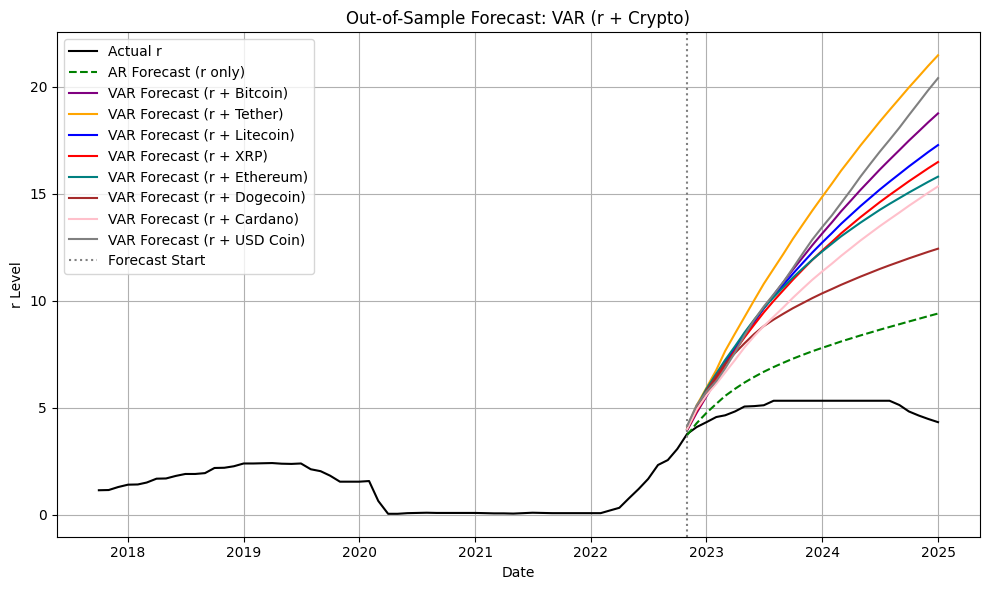

In [1065]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_r, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual r
plt.plot(df['r'], label='Actual r', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (r only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (r only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label='VAR Forecast (r + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (r + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (r + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (r + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (r + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (r + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (r + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (r + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (r + Crypto)')
plt.xlabel('Date')
plt.ylabel('r Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1066]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (r only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['r'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (r only)  MAPE: 46.73%
VAR + BTC    MAPE: 142.94%
VAR + USDT   MAPE: 173.85%
VAR + LTC    MAPE: 133.85%
VAR + XRP    MAPE: 126.38%
VAR + ETH    MAPE: 124.64%
VAR + DOGE   MAPE: 91.40%
VAR + ADA    MAPE: 111.05%
VAR + USDC   MAPE: 152.55%


In [1067]:
from sklearn.metrics import mean_squared_error
import numpy as np

for name, fc in forecasts.items():
    mse  = mean_squared_error(actual, fc)
    rmse = np.sqrt(mse)
    print(f"{name:12s} MSE: {mse:.4f}, RMSE: {rmse:.4f}")




AR (r only)  MSE: 7.4097, RMSE: 2.7221
VAR + BTC    MSE: 69.5010, RMSE: 8.3367
VAR + USDT   MSE: 101.2595, RMSE: 10.0628
VAR + LTC    MSE: 59.0552, RMSE: 7.6847
VAR + XRP    MSE: 52.5105, RMSE: 7.2464
VAR + ETH    MSE: 49.5427, RMSE: 7.0387
VAR + DOGE   MSE: 25.4134, RMSE: 5.0412
VAR + ADA    MSE: 40.7828, RMSE: 6.3861
VAR + USDC   MSE: 80.3930, RMSE: 8.9662


In [1068]:
# Apply the needed differences
diff_orders = {
    "r":      2,
    "Bitcoin":   0,
    "Tether":    1,
    "Litecoin":  0,
    "XRP":       1,
    "Ethereum":  1,
    "Dogecoin":  0,
    "Cardano":   1,
    "USD Coin":  0,
}

df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]

# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()

# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_res = model.select_order(maxlags=6)     # you can choose maxlags=6 or 12, etc.
print(lag_res.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -14.86     -14.56*   3.525e-07      -14.74
1      -17.36      -14.40   2.939e-08      -16.19
2      -17.22      -11.60   3.826e-08      -15.00
3      -17.79      -9.502   3.056e-08      -14.51
4      -17.78      -6.827   6.584e-08      -13.45
5      -18.94      -5.318   9.651e-08      -13.55
6     -25.35*      -9.057  4.367e-09*     -18.90*
-------------------------------------------------


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Checked for zero conditional mean of error assumption

In [1069]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

cryptos = {
    'Bitcoin':  'Bitcoin',
    'Tether':   'usdt_diff',
    'Litecoin': 'Litecoin',
    'XRP':      'xrp_diff',
    'Ethereum': 'eth_diff',
    'Dogecoin': 'Dogecoin',
    'Cardano':  'ada_diff',
    'USD Coin': 'USD Coin',
}

p = 6
f_test_results = {}

for name, col in cryptos.items():
    # 1) Fit VAR
    df2   = train[['r_diff', col]].dropna()
    res   = VAR(df2).fit(p)

    # 2) Extract r‐residuals
    resid_df = pd.DataFrame(
        res.resid, 
        index=df2.index[p:]
    )
    eps_r    = resid_df.iloc[:, 0]

    # 3) Build lag matrix Z
    lags = {f"r_lag{i}": df2['r_diff'].shift(i) for i in range(1, p+1)}
    lags.update({f"{name}_lag{i}": df2[col].shift(i) for i in range(0, p+1)})
    Z = pd.DataFrame(lags).dropna().loc[eps_r.index]
    eps_r = eps_r.loc[Z.index]

    # 4) Aux OLS
    aux = sm.OLS(eps_r, sm.add_constant(Z)).fit()

    # 5) Wald χ² on the crypto lags
    crypto_terms = [f"{name}_lag{i}" for i in range(p+1)]
    R = np.zeros((p+1, aux.params.shape[0]))
    param_idx = {param: i for i, param in enumerate(aux.params.index)}
    for i, term in enumerate(crypto_terms):
        R[i, param_idx[term]] = 1.0

    wald = aux.wald_test(R)  # asymptotic χ²
    f_test_results[name] = {
        'χ² statistic': float(wald.statistic),
        'p-value':       float(wald.pvalue)
    }

# Summarize
f_test_df = pd.DataFrame(f_test_results).T
print(f_test_df)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/2087160756.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Des

          χ² statistic   p-value
Bitcoin       0.060987  0.999608
Tether        0.041177  0.999894
Litecoin      0.191056  0.985692
XRP           0.036977  0.999927
Ethereum      0.111797  0.997207
Dogecoin      0.133500  0.995139
Cardano       0.150790  0.992834
USD Coin      0.162373  0.990548


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/2087160756.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),


## VAR Forecasting on LFPR with all crypto

USDC improves MAPE by 0.66%, USDT by 0.52%

In [1070]:
# Split the data into training and testing sets
train = df.loc['2018-09':'2022-10']
test = df.loc['2022-11': '2025-1']

In [1071]:
# Because lfpr is non-stationary with order 1, need to difference it
df['lfpr_diff'] = df['LFPR'].diff(1)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])



In [1072]:
train['lfpr_diff'] = train['LFPR'].diff(1)
train['usdt_diff'] = train['Tether'].diff(1)
train['xrp_diff'] = train['XRP'].diff(1)
train['eth_diff'] = train['Ethereum'].diff(1)
train['ada_diff'] = train['Cardano'].diff(1)

In [1073]:
from statsmodels.tsa.api import AutoReg

# Ensure 'lfpr_diff' exists in train
if 'lfpr_diff' not in train.columns:
	train['lfpr_diff'] = df['lfpr_diff'].loc[train.index]

# Drop NaNs from the training data
lfpr_diff_train = train['lfpr_diff'].dropna()

model_ar = AutoReg(lfpr_diff_train, lags=1)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1074]:
lfpr_start = df['LFPR'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + lfpr_start

In [1075]:

p = 6

# Ensure train has the latest differenced columns from df
train = df.loc['2018-09':'2022-10']

# Fit VAR model on lfpr_diff and Bitcoin
model_btc = VAR(train[['lfpr_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['lfpr_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and usdt_diff
if 'usdt_diff' not in train.columns:
	train['usdt_diff'] = df['usdt_diff'].loc[train.index]
model_usdt = VAR(train[['lfpr_diff', 'usdt_diff']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['lfpr_diff', 'usdt_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and Litecoin
model_ltc = VAR(train[['lfpr_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['lfpr_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and xrp_diff
model_xrp = VAR(train[['lfpr_diff', 'xrp_diff']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['lfpr_diff', 'xrp_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and eth_diff
model_eth = VAR(train[['lfpr_diff', 'eth_diff']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['lfpr_diff', 'eth_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and Dogecoin
model_doge = VAR(train[['lfpr_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['lfpr_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and ada_diff
model_ada = VAR(train[['lfpr_diff', 'ada_diff']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['lfpr_diff', 'ada_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + lfpr_start, index=test.index)

# Fit VAR model on lfpr_diff and USD Coin
model_usdc = VAR(train[['lfpr_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['lfpr_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + lfpr_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

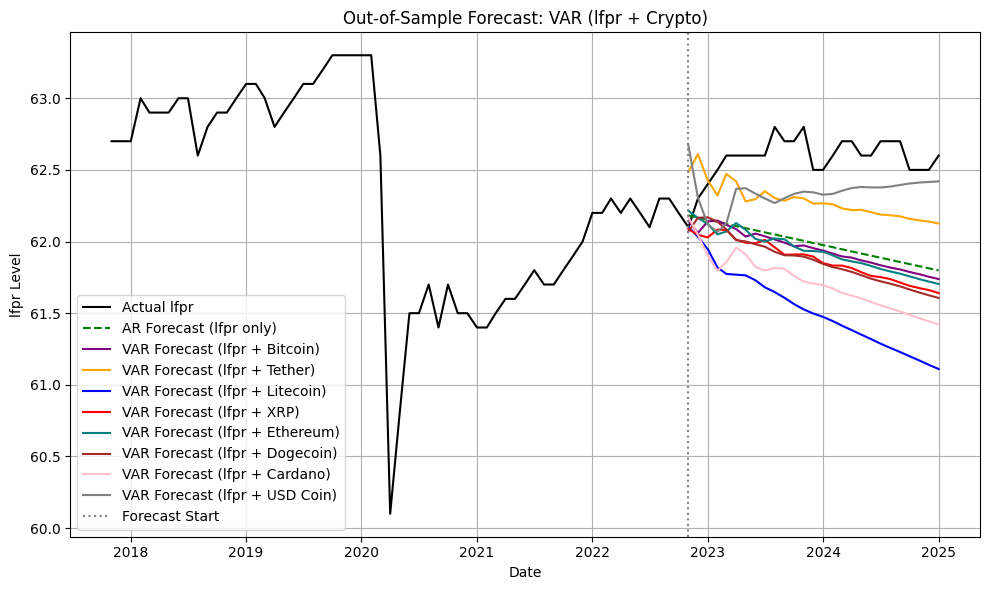

In [1076]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_lfpr, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual lfpr
plt.plot(df['LFPR'], label='Actual lfpr', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (lfpr only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (lfpr only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label='VAR Forecast (lfpr + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (lfpr + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (lfpr + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (lfpr + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (lfpr + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (lfpr + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (lfpr + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (lfpr + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (lfpr + Crypto)')
plt.xlabel('Date')
plt.ylabel('lfpr Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1077]:
import pandas as pd
from statsmodels.tsa.api import VAR

# Apply the needed differences
diff_orders = {
    "LFPR":      1,
    "Bitcoin":   0,
    "Tether":    1,
    "Litecoin":  0,
    "XRP":       1,
    "Ethereum":  1,
    "Dogecoin":  0,
    "Cardano":   1,
    "USD Coin":  0,
}

df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]

# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()

# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_res = model.select_order(maxlags=6)     # you can choose maxlags=6 or 12, etc.
print(lag_res.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -15.12     -14.82*   2.714e-07      -15.00
1      -16.40      -13.44   7.660e-08      -15.23
2      -16.44      -10.81   8.371e-08      -14.21
3      -17.08      -8.784   6.263e-08      -13.80
4      -17.00      -6.040   1.446e-07      -12.66
5      -17.82      -4.198   2.959e-07      -12.43
6     -23.13*      -6.843  3.997e-08*     -16.69*
-------------------------------------------------


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Looking at AIC and HQIC minimums, we pick lag p=6

In [1078]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (lfpr only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['LFPR'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (lfpr only) MAPE: 0.95%
VAR + BTC    MAPE: 1.02%
VAR + USDT   MAPE: 0.56%
VAR + LTC    MAPE: 1.68%
VAR + XRP    MAPE: 1.13%
VAR + ETH    MAPE: 1.04%
VAR + DOGE   MAPE: 1.13%
VAR + ADA    MAPE: 1.39%
VAR + USDC   MAPE: 0.45%


Checked for zero conditional mean of error assumption

In [1079]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

cryptos = {
    'Bitcoin':  'Bitcoin',
    'Tether':   'usdt_diff',
    'Litecoin': 'Litecoin',
    'XRP':      'xrp_diff',
    'Ethereum': 'eth_diff',
    'Dogecoin': 'Dogecoin',
    'Cardano':  'ada_diff',
    'USD Coin': 'USD Coin',
}

p = 6
f_test_results = {}

for name, col in cryptos.items():
    # 1) Fit VAR
    df2   = train[['lfpr_diff', col]].dropna()
    res   = VAR(df2).fit(p)

    # 2) Extract r‐residuals
    resid_df = pd.DataFrame(
        res.resid, 
        index=df2.index[p:]
    )
    eps_lfpr    = resid_df.iloc[:, 0]

    # 3) Build lag matrix Z
    lags = {f"lfpr_lag{i}": df2['lfpr_diff'].shift(i) for i in range(1, p+1)}
    lags.update({f"{name}_lag{i}": df2[col].shift(i) for i in range(0, p+1)})
    Z = pd.DataFrame(lags).dropna().loc[eps_lfpr.index]
    eps_lfpr = eps_lfpr.loc[Z.index]

    # 4) Aux OLS
    aux = sm.OLS(eps_lfpr, sm.add_constant(Z)).fit()

    # 5) Wald χ² on the crypto lags
    crypto_terms = [f"{name}_lag{i}" for i in range(p+1)]
    R = np.zeros((p+1, aux.params.shape[0]))
    param_idx = {param: i for i, param in enumerate(aux.params.index)}
    for i, term in enumerate(crypto_terms):
        R[i, param_idx[term]] = 1.0

    wald = aux.wald_test(R)  # asymptotic χ²
    f_test_results[name] = {
        'χ² statistic': float(wald.statistic),
        'p-value':       float(wald.pvalue)
    }

# Summarize
f_test_df = pd.DataFrame(f_test_results).T
print(f_test_df)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/28197102.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Deskt

          χ² statistic   p-value
Bitcoin       0.374229  0.910101
Tether        0.167169  0.989950
Litecoin      0.766532  0.619446
XRP           0.506652  0.822097
Ethereum      1.590471  0.176515
Dogecoin      0.303692  0.946659
Cardano       1.321192  0.274721
USD Coin      0.759303  0.625633


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/28197102.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),


## VAR Forecasting on GDP and all crypto

USDC improves MAPE by 0.34%, USDT by 0.12%, ETH by 0.15%

In [1080]:
# Split the data into training and testing sets
train = df.loc['2018-01':'2022-10']
test = df.loc['2022-11': '2025-1']

In [1081]:
# Apply the needed differences
diff_orders = {
    "GDP":      1,
    "Bitcoin":   0,
    "Tether":    1,
    "Litecoin":  0,
    "XRP":       1,
    "Ethereum":  1,
    "Dogecoin":  0,
    "Cardano":   1,
    "USD Coin":  0,
}

df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]

# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()

# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_res = model.select_order(maxlags=6)     # you can choose maxlags=6 or 12, etc.
print(lag_res.summary())


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      0.4590     0.7551*       1.583      0.5762
1     -0.8142       2.147      0.4520      0.3576
2     -0.6094       5.017      0.6278       1.617
3      -1.048       7.244      0.5726       2.233
4     -0.8162       10.14       1.541       3.520
5      -2.472       11.15       1.371       2.919
6     -9.445*       6.844    0.03513*     -2.999*
-------------------------------------------------


In [1082]:
# Because lfpr is non-stationary with order 1, need to difference it
df['gdp_diff'] = df['GDP Monthly'].diff(1)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])

In [1083]:
from statsmodels.tsa.api import AutoReg

# Ensure 'gdp_diff' exists in train
if 'gdp_diff' not in train.columns:
	train['gdp_diff'] = df['gdp_diff'].loc[train.index]

# Drop NaNs from the training data
gdp_diff_train = train['gdp_diff'].dropna()

model_ar = AutoReg(gdp_diff_train, lags=2)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1084]:
gdp_start = df['GDP Monthly'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + gdp_start

In [1085]:

p = 6

# Ensure train has the latest differenced columns from df
train = df.loc['2017-09':'2022-10']

# Fit VAR model on gdp_diff and Bitcoin
model_btc = VAR(train[['gdp_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['gdp_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and usdt_diff
if 'usdt_diff' not in train.columns:
	train['usdt_diff'] = df['usdt_diff'].loc[train.index]
model_usdt = VAR(train[['gdp_diff', 'usdt_diff']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['gdp_diff', 'usdt_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and Litecoin
model_ltc = VAR(train[['gdp_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['gdp_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and xrp_diff
model_xrp = VAR(train[['gdp_diff', 'xrp_diff']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['gdp_diff', 'xrp_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and eth_diff
model_eth = VAR(train[['gdp_diff', 'eth_diff']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['gdp_diff', 'eth_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and Dogecoin
model_doge = VAR(train[['gdp_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['gdp_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and ada_diff
model_ada = VAR(train[['gdp_diff', 'ada_diff']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['gdp_diff', 'ada_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + gdp_start, index=test.index)

# Fit VAR model on gdp_diff and USD Coin
model_usdc = VAR(train[['gdp_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['gdp_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + gdp_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

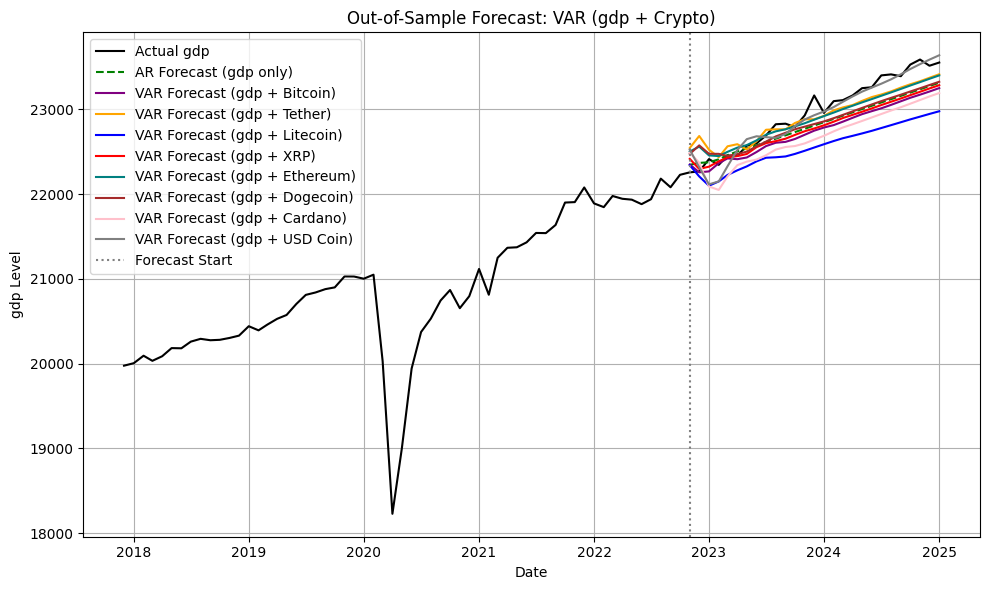

In [1086]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_gdp, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual gdp
plt.plot(df['GDP Monthly'], label='Actual gdp', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (gdp only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (gdp only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label='VAR Forecast (gdp + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (gdp + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (gdp + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (gdp + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (gdp + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (gdp + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (gdp + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (gdp + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (gdp + Crypto)')
plt.xlabel('Date')
plt.ylabel('gdp Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1087]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (gdp only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['GDP Monthly'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (gdp only) MAPE: 0.72%
VAR + BTC    MAPE: 0.95%
VAR + USDT   MAPE: 0.60%
VAR + LTC    MAPE: 1.75%
VAR + XRP    MAPE: 0.83%
VAR + ETH    MAPE: 0.57%
VAR + DOGE   MAPE: 0.75%
VAR + ADA    MAPE: 1.37%
VAR + USDC   MAPE: 0.38%


In [1088]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

cryptos = {
    'Bitcoin':  'Bitcoin',
    'Tether':   'usdt_diff',
    'Litecoin': 'Litecoin',
    'XRP':      'xrp_diff',
    'Ethereum': 'eth_diff',
    'Dogecoin': 'Dogecoin',
    'Cardano':  'ada_diff',
    'USD Coin': 'USD Coin',
}

p = 6
f_test_results = {}

for name, col in cryptos.items():
    # 1) Fit VAR
    df2   = train[['gdp_diff', col]].dropna()
    res   = VAR(df2).fit(p)

    # 2) Extract r‐residuals
    resid_df = pd.DataFrame(
        res.resid, 
        index=df2.index[p:]
    )
    eps_gdp    = resid_df.iloc[:, 0]

    # 3) Build lag matrix Z
    lags = {f"gdp_lag{i}": df2['gdp_diff'].shift(i) for i in range(1, p+1)}
    lags.update({f"{name}_lag{i}": df2[col].shift(i) for i in range(0, p+1)})
    Z = pd.DataFrame(lags).dropna().loc[eps_gdp.index]
    eps_gdp = eps_gdp.loc[Z.index]

    # 4) Aux OLS
    aux = sm.OLS(eps_gdp, sm.add_constant(Z)).fit()

    # 5) Wald χ² on the crypto lags
    crypto_terms = [f"{name}_lag{i}" for i in range(p+1)]
    R = np.zeros((p+1, aux.params.shape[0]))
    param_idx = {param: i for i, param in enumerate(aux.params.index)}
    for i, term in enumerate(crypto_terms):
        R[i, param_idx[term]] = 1.0

    wald = aux.wald_test(R)  # asymptotic χ²
    f_test_results[name] = {
        'χ² statistic': float(wald.statistic),
        'p-value':       float(wald.pvalue)
    }

# Summarize
f_test_df = pd.DataFrame(f_test_results).T
print(f_test_df)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/2463146763.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Des

          χ² statistic   p-value
Bitcoin       0.244718  0.970934
Tether        0.155323  0.992249
Litecoin      0.385271  0.905353
XRP           0.174029  0.989100
Ethereum      1.349266  0.254075
Dogecoin      0.229658  0.975661
Cardano       1.112202  0.376806
USD Coin      0.844702  0.561178


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/2463146763.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Des

## VAR Forecasting on CPI with all crypto

DOGE improves MAPE by 0.24%, XRP by 0.19%, ETH by 0.15%, USDT by 0.14%, LTC by 0.12%

In [1089]:
# Split the data into training and testing sets
train = df.loc['2018-01':'2022-10']
test = df.loc['2022-11': '2025-1']

In [1090]:
# Apply the needed differences
diff_orders = {
    "CPI":      2,
    "Bitcoin":   0,
    "Tether":    1,
    "Litecoin":  0,
    "XRP":       1,
    "Ethereum":  1,
    "Dogecoin":  0,
    "Cardano":   1,
    "USD Coin":  0,
}

df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]

# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()

# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_res = model.select_order(maxlags=6)     # you can choose maxlags=6 or 12, etc.
print(lag_res.summary())


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -11.90     -11.60*   6.793e-06      -11.78
1      -13.96      -11.00   8.862e-07      -12.78
2      -14.42      -8.789   6.334e-07      -12.19
3      -15.26      -6.964   3.867e-07      -11.97
4      -15.32      -4.362   7.740e-07      -10.98
5      -16.80      -3.174   8.236e-07      -11.41
6     -22.35*      -6.061  8.732e-08*     -15.90*
-------------------------------------------------


In [1091]:
# Because lfpr is non-stationary with order 1, need to difference it
df['cpi_diff'] = df['CPI'].diff(1)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])

In [1092]:
from statsmodels.tsa.api import AutoReg

# Ensure 'cpi_diff' exists in train
if 'cpi_diff' not in train.columns:
	train['cpi_diff'] = df['cpi_diff'].loc[train.index]

# Drop NaNs from the training data
cpi_diff_train = train['cpi_diff'].dropna()

model_ar = AutoReg(cpi_diff_train, lags=1)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1093]:
cpi_start = df['CPI'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + cpi_start

In [1094]:

p = 6

# Ensure train has the latest differenced columns from df
train = df.loc['2017-09':'2022-10']

# Fit VAR model on cpi_diff and Bitcoin
model_btc = VAR(train[['cpi_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['cpi_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + cpi_start, index=test.index)

# Fit VAR model on cpi_diff and usdt_diff
if 'usdt_diff' not in train.columns:
	train['usdt_diff'] = df['usdt_diff'].loc[train.index]
model_usdt = VAR(train[['cpi_diff', 'usdt_diff']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['cpi_diff', 'usdt_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + cpi_start, index=test.index)

# Fit VAR model on cpi_diff and Litecoin
model_ltc = VAR(train[['cpi_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['cpi_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + cpi_start, index=test.index)

# Fit VAR model on cpi_diff and xrp_diff
model_xrp = VAR(train[['cpi_diff', 'xrp_diff']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['cpi_diff', 'xrp_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + cpi_start, index=test.index)

# Fit VAR model on cpi_diff and eth_diff
model_eth = VAR(train[['cpi_diff', 'eth_diff']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['cpi_diff', 'eth_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + cpi_start, index=test.index)

# Fit VAR model on cpi_diff and Dogecoin
model_doge = VAR(train[['cpi_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['cpi_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + cpi_start, index=test.index)

# Fit VAR model on cpi_diff and ada_diff
model_ada = VAR(train[['cpi_diff', 'ada_diff']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['cpi_diff', 'ada_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + cpi_start, index=test.index)

# Fit VAR model on cpi_diff and USD Coin
model_usdc = VAR(train[['cpi_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['cpi_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + cpi_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

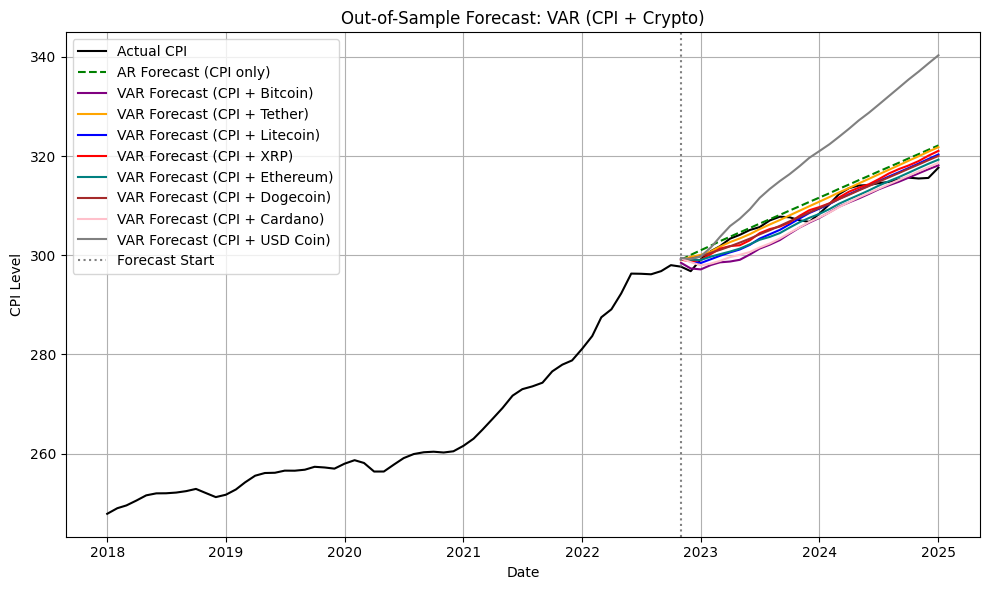

In [1095]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_gdp, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual gdp
plt.plot(df['CPI'], label='Actual CPI', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (gdp only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (CPI only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label='VAR Forecast (CPI + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (CPI + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (CPI + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (CPI + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (CPI + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (CPI + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (CPI + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (CPI + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (CPI + Crypto)')
plt.xlabel('Date')
plt.ylabel('CPI Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1096]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (CPI only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['CPI'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (CPI only) MAPE: 0.68%
VAR + BTC    MAPE: 0.73%
VAR + USDT   MAPE: 0.54%
VAR + LTC    MAPE: 0.56%
VAR + XRP    MAPE: 0.49%
VAR + ETH    MAPE: 0.53%
VAR + DOGE   MAPE: 0.44%
VAR + ADA    MAPE: 0.71%
VAR + USDC   MAPE: 3.37%


In [1097]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

cryptos = {
    'Bitcoin':  'Bitcoin',
    'Tether':   'usdt_diff',
    'Litecoin': 'Litecoin',
    'XRP':      'xrp_diff',
    'Ethereum': 'eth_diff',
    'Dogecoin': 'Dogecoin',
    'Cardano':  'ada_diff',
    'USD Coin': 'USD Coin',
}

p = 6
f_test_results = {}

for name, col in cryptos.items():
    # 1) Fit VAR
    df2   = train[['cpi_diff', col]].dropna()
    res   = VAR(df2).fit(p)

    # 2) Extract r‐residuals
    resid_df = pd.DataFrame(
        res.resid, 
        index=df2.index[p:]
    )
    eps_cpi    = resid_df.iloc[:, 0]

    # 3) Build lag matrix Z
    lags = {f"cpi_lag{i}": df2['cpi_diff'].shift(i) for i in range(1, p+1)}
    lags.update({f"{name}_lag{i}": df2[col].shift(i) for i in range(0, p+1)})
    Z = pd.DataFrame(lags).dropna().loc[eps_cpi.index]
    eps_cpi = eps_cpi.loc[Z.index]

    # 4) Aux OLS
    aux = sm.OLS(eps_cpi, sm.add_constant(Z)).fit()

    # 5) Wald χ² on the crypto lags
    crypto_terms = [f"{name}_lag{i}" for i in range(p+1)]
    R = np.zeros((p+1, aux.params.shape[0]))
    param_idx = {param: i for i, param in enumerate(aux.params.index)}
    for i, term in enumerate(crypto_terms):
        R[i, param_idx[term]] = 1.0

    wald = aux.wald_test(R)  # asymptotic χ²
    f_test_results[name] = {
        'χ² statistic': float(wald.statistic),
        'p-value':       float(wald.pvalue)
    }

# Summarize
f_test_df = pd.DataFrame(f_test_results).T
print(f_test_df)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/1792542081.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Des

          χ² statistic   p-value
Bitcoin       0.047176  0.999832
Tether        0.147560  0.993343
Litecoin      0.003756  1.000000
XRP           0.006539  1.000000
Ethereum      0.061852  0.999585
Dogecoin      0.031378  0.999958
Cardano       0.017979  0.999994
USD Coin      0.012777  0.999998


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/1792542081.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),


## VAR Forecast on M1 Money supply with all crypto

ETH improves MAPE by 4.03%, ADA by 2.93%, DOGE by 1.52%, USDC by 1.28%

In [1098]:
# Apply the needed differences
diff_orders = {
    "M1":      1,
    "Bitcoin":   0,
    "Tether":    1,
    "Litecoin":  0,
    "XRP":       1,
    "Ethereum":  1,
    "Dogecoin":  0,
    "Cardano":   1,
    "USD Coin":  0,
}

df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]

# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()

# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_res = model.select_order(maxlags=6)     # you can choose maxlags=6 or 12, etc.
print(lag_res.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       1.398      1.694*       4.048       1.515
1      0.1273       3.089       1.159       1.299
2      0.4362       6.063       1.786       2.663
3     -0.5857       7.707      0.9092       2.696
4     -0.5619       10.40       1.987       3.774
5      -1.505       12.12       3.604       3.885
6     -8.380*       7.909     0.1019*     -1.934*
-------------------------------------------------


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [1099]:
# Because lfpr is non-stationary with order 1, need to difference it
df['m1_diff'] = df['M1'].diff(1)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])

In [1100]:
from statsmodels.tsa.api import AutoReg

# Ensure 'm1_diff' exists in train
if 'm1_diff' not in train.columns:
	# Only assign values where the index exists in both
	common_idx = train.index.intersection(df['m1_diff'].dropna().index)
	train.loc[common_idx, 'm1_diff'] = df.loc[common_idx, 'm1_diff']

# Drop NaNs from the training data
m1_diff_train = train['m1_diff'].dropna()

model_ar = AutoReg(m1_diff_train, lags=1)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1101]:
m1_start = df['M1'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + m1_start

In [1102]:

p = 6

# Ensure train has the latest differenced columns from df
train = df.loc['2017-09':'2022-10']

# Fit VAR model on m1_diff and Bitcoin
model_btc = VAR(train[['m1_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['m1_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + m1_start, index=test.index)

# Fit VAR model on m1_diff and usdt_diff
if 'usdt_diff' not in train.columns:
	train['usdt_diff'] = df['usdt_diff'].loc[train.index]
model_usdt = VAR(train[['m1_diff', 'usdt_diff']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['m1_diff', 'usdt_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + m1_start, index=test.index)

# Fit VAR model on m1_diff and Litecoin
model_ltc = VAR(train[['m1_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['m1_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + m1_start, index=test.index)

# Fit VAR model on m1_diff and xrp_diff
model_xrp = VAR(train[['m1_diff', 'xrp_diff']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['m1_diff', 'xrp_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + m1_start, index=test.index)

# Fit VAR model on m1_diff and eth_diff
model_eth = VAR(train[['m1_diff', 'eth_diff']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['m1_diff', 'eth_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + m1_start, index=test.index)

# Fit VAR model on m1_diff and Dogecoin
model_doge = VAR(train[['m1_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['m1_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + m1_start, index=test.index)

# Fit VAR model on m1_diff and ada_diff
model_ada = VAR(train[['m1_diff', 'ada_diff']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['m1_diff', 'ada_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + m1_start, index=test.index)

# Fit VAR model on m1_diff and USD Coin
model_usdc = VAR(train[['m1_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['m1_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + m1_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

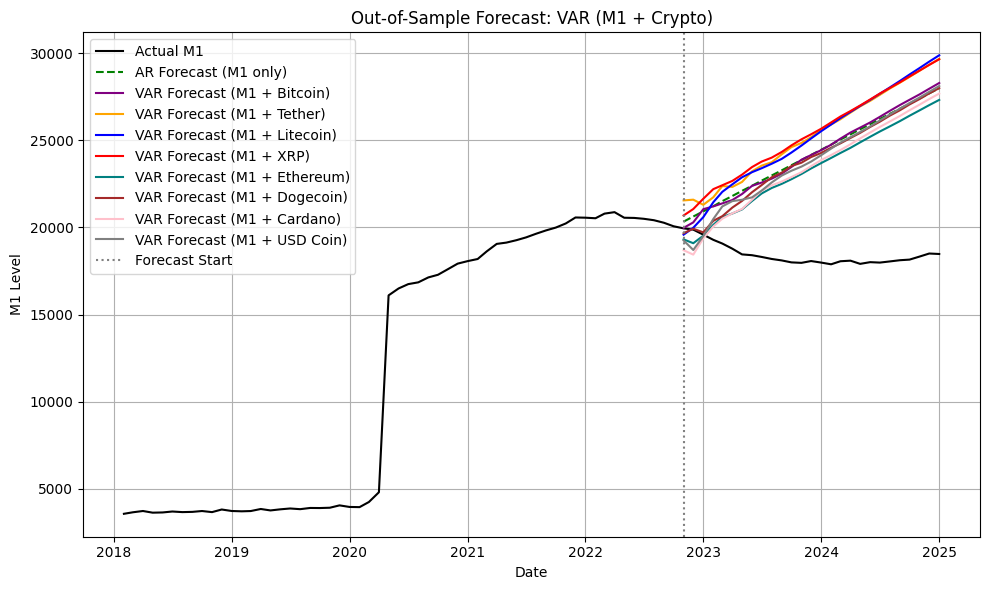

In [1103]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_gdp, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual gdp
plt.plot(df['M1'], label='Actual M1', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (gdp only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (M1 only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label='VAR Forecast (M1 + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (M1 + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (M1 + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (M1 + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (M1 + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (M1 + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (M1 + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (M1 + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (M1 + Crypto)')
plt.xlabel('Date')
plt.ylabel('M1 Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1104]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (M1 only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['M1'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (M1 only) MAPE: 31.48%
VAR + BTC    MAPE: 31.52%
VAR + USDT   MAPE: 37.44%
VAR + LTC    MAPE: 36.73%
VAR + XRP    MAPE: 37.92%
VAR + ETH    MAPE: 27.45%
VAR + DOGE   MAPE: 29.96%
VAR + ADA    MAPE: 28.55%
VAR + USDC   MAPE: 30.20%


In [1105]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

cryptos = {
    'Bitcoin':  'Bitcoin',
    'Tether':   'usdt_diff',
    'Litecoin': 'Litecoin',
    'XRP':      'xrp_diff',
    'Ethereum': 'eth_diff',
    'Dogecoin': 'Dogecoin',
    'Cardano':  'ada_diff',
    'USD Coin': 'USD Coin',
}

p = 6
f_test_results = {}

for name, col in cryptos.items():
    # 1) Fit VAR
    df2   = train[['m1_diff', col]].dropna()
    res   = VAR(df2).fit(p)

    # 2) Extract r‐residuals
    resid_df = pd.DataFrame(
        res.resid, 
        index=df2.index[p:]
    )
    eps_m1    = resid_df.iloc[:, 0]

    # 3) Build lag matrix Z
    lags = {f"m1_lag{i}": df2['m1_diff'].shift(i) for i in range(1, p+1)}
    lags.update({f"{name}_lag{i}": df2[col].shift(i) for i in range(0, p+1)})
    Z = pd.DataFrame(lags).dropna().loc[eps_m1.index]
    eps_m1 = eps_m1.loc[Z.index]

    # 4) Aux OLS
    aux = sm.OLS(eps_m1, sm.add_constant(Z)).fit()

    # 5) Wald χ² on the crypto lags
    crypto_terms = [f"{name}_lag{i}" for i in range(p+1)]
    R = np.zeros((p+1, aux.params.shape[0]))
    param_idx = {param: i for i, param in enumerate(aux.params.index)}
    for i, term in enumerate(crypto_terms):
        R[i, param_idx[term]] = 1.0

    wald = aux.wald_test(R)  # asymptotic χ²
    f_test_results[name] = {
        'χ² statistic': float(wald.statistic),
        'p-value':       float(wald.pvalue)
    }

# Summarize
f_test_df = pd.DataFrame(f_test_results).T
print(f_test_df)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/2393884558.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Des

          χ² statistic   p-value
Bitcoin       0.002715  1.000000
Tether        0.095481  0.998287
Litecoin      0.129423  0.995533
XRP           0.155546  0.992158
Ethereum      0.001913  1.000000
Dogecoin      0.002444  1.000000
Cardano       0.022140  0.999987
USD Coin      0.037056  0.999919


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/2393884558.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Des

## VAR Forecasting on IM with all crypto

BTC improves MAPE by 1.48%, XRP by 0.46%, DOGE 0.93%. ADA by 0.50%

In [1106]:
# Apply the needed differences
diff_orders = {
    "IM":      1,
    "Bitcoin":   0,
    "Tether":    1,
    "Litecoin":  0,
    "XRP":       1,
    "Ethereum":  1,
    "Dogecoin":  0,
    "Cardano":   1,
    "USD Coin":  0,
}

df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]

# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()

# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_res = model.select_order(maxlags=6)     # you can choose maxlags=6 or 12, etc.
print(lag_res.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -3.497     -3.201*     0.03029      -3.380
1      -4.775      -1.813    0.008614      -3.603
2      -4.476       1.151     0.01314      -2.249
3      -4.966       3.326     0.01138      -1.685
4      -4.799       6.159     0.02871     -0.4631
5      -6.081       7.542     0.03713     -0.6903
6     -13.32*       2.971  0.0007304*     -6.872*
-------------------------------------------------


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [1107]:
# Because lfpr is non-stationary with order 1, need to difference it
df['im_diff'] = df['IM'].diff(1)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])

In [1108]:
from statsmodels.tsa.api import AutoReg

# Ensure 'im_diff' exists in train
if 'im_diff' not in train.columns:
    # Only assign values where the index exists in both
    common_idx = train.index.intersection(df['im_diff'].dropna().index)
    train.loc[common_idx, 'im_diff'] = df.loc[common_idx, 'im_diff']

# Drop NaNs from the training data
im_diff_train = train['im_diff'].dropna()

model_ar = AutoReg(im_diff_train, lags=3)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1109]:
im_start = df['IM'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + im_start

In [1110]:

p = 6

# Ensure train has the latest differenced columns from df
train = df.loc['2017-09':'2022-10']

# Fit VAR model on im_diff and Bitcoin
model_btc = VAR(train[['im_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['im_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + im_start, index=test.index)

# Fit VAR model on im_diff and usdt_diff
if 'usdt_diff' not in train.columns:
	train['usdt_diff'] = df['usdt_diff'].loc[train.index]
model_usdt = VAR(train[['im_diff', 'usdt_diff']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['im_diff', 'usdt_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + im_start, index=test.index)

# Fit VAR model on im_diff and Litecoin
model_ltc = VAR(train[['im_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['im_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + im_start, index=test.index)

# Fit VAR model on im_diff and xrp_diff
model_xrp = VAR(train[['im_diff', 'xrp_diff']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['im_diff', 'xrp_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + im_start, index=test.index)

# Fit VAR model on im_diff and eth_diff
model_eth = VAR(train[['im_diff', 'eth_diff']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['im_diff', 'eth_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + im_start, index=test.index)

# Fit VAR model on im_diff and Dogecoin
model_doge = VAR(train[['im_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['im_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + im_start, index=test.index)

# Fit VAR model on im_diff and ada_diff
model_ada = VAR(train[['im_diff', 'ada_diff']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['im_diff', 'ada_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + im_start, index=test.index)

# Fit VAR model on im_diff and USD Coin
model_usdc = VAR(train[['im_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['im_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + im_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

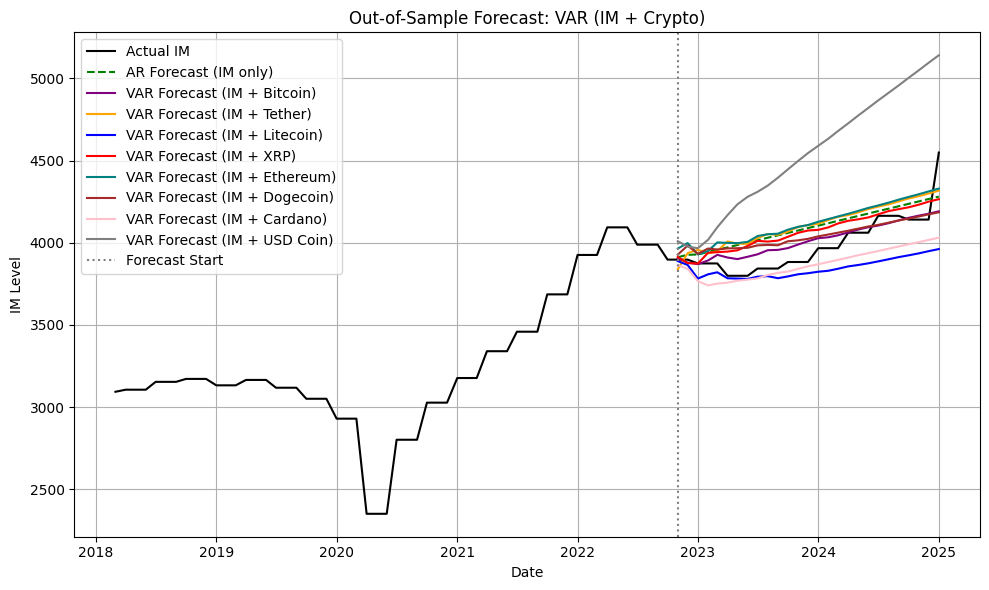

In [1111]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_gdp, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual gdp
plt.plot(df['IM'], label='Actual IM', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (gdp only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (IM only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label = 'VAR Forecast (IM + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (IM + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (IM + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (IM + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (IM + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (IM + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (IM + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (IM + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (IM + Crypto)')
plt.xlabel('Date')
plt.ylabel('IM Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1112]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (CPI only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['IM'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (CPI only) MAPE: 3.21%
VAR + BTC    MAPE: 1.73%
VAR + USDT   MAPE: 3.64%
VAR + LTC    MAPE: 3.31%
VAR + XRP    MAPE: 2.75%
VAR + ETH    MAPE: 3.86%
VAR + DOGE   MAPE: 2.38%
VAR + ADA    MAPE: 2.71%
VAR + USDC   MAPE: 13.83%


Checked for zero conditional mean of error and Ethereum has a p-value 0.04<0.05, this means that it violates the zero conditional mean of error assumption

In [1113]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

cryptos = {
    'Bitcoin':  'Bitcoin',
    'Tether':   'usdt_diff',
    'Litecoin': 'Litecoin',
    'XRP':      'xrp_diff',
    'Ethereum': 'eth_diff',
    'Dogecoin': 'Dogecoin',
    'Cardano':  'ada_diff',
    'USD Coin': 'USD Coin',
}

p = 6
f_test_results = {}

for name, col in cryptos.items():
    # 1) Fit VAR
    df2   = train[['im_diff', col]].dropna()
    res   = VAR(df2).fit(p)

    # 2) Extract r‐residuals
    resid_df = pd.DataFrame(
        res.resid, 
        index=df2.index[p:]
    )
    eps_im    = resid_df.iloc[:, 0]

    # 3) Build lag matrix Z
    lags = {f"im_lag{i}": df2['im_diff'].shift(i) for i in range(1, p+1)}
    lags.update({f"{name}_lag{i}": df2[col].shift(i) for i in range(0, p+1)})
    Z = pd.DataFrame(lags).dropna().loc[eps_im.index]
    eps_im = eps_im.loc[Z.index]

    # 4) Aux OLS
    aux = sm.OLS(eps_im, sm.add_constant(Z)).fit()

    # 5) Wald χ² on the crypto lags
    crypto_terms = [f"{name}_lag{i}" for i in range(p+1)]
    R = np.zeros((p+1, aux.params.shape[0]))
    param_idx = {param: i for i, param in enumerate(aux.params.index)}
    for i, term in enumerate(crypto_terms):
        R[i, param_idx[term]] = 1.0

    wald = aux.wald_test(R)  # asymptotic χ²
    f_test_results[name] = {
        'χ² statistic': float(wald.statistic),
        'p-value':       float(wald.pvalue)
    }

# Summarize
f_test_df = pd.DataFrame(f_test_results).T
print(f_test_df)


          χ² statistic   p-value
Bitcoin       1.041107  0.420450
Tether        0.004628  1.000000
Litecoin      1.449084  0.216664
XRP           0.871255  0.538289
Ethereum      2.389903  0.040833
Dogecoin      0.000156  1.000000
Cardano       1.081239  0.395381
USD Coin      0.031070  0.999955


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/4203680997.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Des

## VAR Forecasting on EX with all crypto

BTC improves MAPE by 0.38%

In [1114]:
diff_orders = {
    "EX": 1,
    "Bitcoin": 0, 
    "Tether": 1,
    "Litecoin": 0,
    "XRP": 1,
    "Ethereum": 1,
    "Dogecoin": 0,
    "Cardano": 1,
    "USD Coin": 0,    
}
df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]
# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()
# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_Res = model.select_order(maxlags=6)
print(lag_res.summary())


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -3.497     -3.201*     0.03029      -3.380
1      -4.775      -1.813    0.008614      -3.603
2      -4.476       1.151     0.01314      -2.249
3      -4.966       3.326     0.01138      -1.685
4      -4.799       6.159     0.02871     -0.4631
5      -6.081       7.542     0.03713     -0.6903
6     -13.32*       2.971  0.0007304*     -6.872*
-------------------------------------------------


In [1115]:
# Because lfpr is non-stationary with order 1, need to difference it
df['ex_diff'] = df['EX'].diff(1)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])

In [1116]:
from statsmodels.tsa.api import AutoReg

# Ensure 'ex_diff' exists in train
if 'ex_diff' not in train.columns:
    # Only assign values where the index exists in both
    common_idx = train.index.intersection(df['ex_diff'].dropna().index)
    train.loc[common_idx, 'ex_diff'] = df.loc[common_idx, 'ex_diff']

# Drop NaNs from the training data
ex_diff_train = train['ex_diff'].dropna()

model_ar = AutoReg(ex_diff_train, lags=3)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1117]:
ex_start = df['EX'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + ex_start

In [1118]:
p = 6

# Ensure train has the latest differenced columns from df
train = df.loc['2017-09':'2022-10']

# Fit VAR model on ex_diff and Bitcoin
model_btc = VAR(train[['ex_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['ex_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + ex_start, index=test.index)

# Fit VAR model on ex_diff and usdt_diff
if 'usdt_diff' not in train.columns:
	train['usdt_diff'] = df['usdt_diff'].loc[train.index]
model_usdt = VAR(train[['ex_diff', 'usdt_diff']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['ex_diff', 'usdt_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + ex_start, index=test.index)

# Fit VAR model on ex_diff and Litecoin
model_ltc = VAR(train[['ex_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['ex_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + ex_start, index=test.index)

# Fit VAR model on ex_diff and xrp_diff
model_xrp = VAR(train[['ex_diff', 'xrp_diff']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['ex_diff', 'xrp_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + ex_start, index=test.index)

# Fit VAR model on ex_diff and eth_diff
model_eth = VAR(train[['ex_diff', 'eth_diff']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['ex_diff', 'eth_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + ex_start, index=test.index)

# Fit VAR model on ex_diff and Dogecoin
model_doge = VAR(train[['ex_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['ex_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + ex_start, index=test.index)

# Fit VAR model on ex_diff and ada_diff
model_ada = VAR(train[['ex_diff', 'ada_diff']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['ex_diff', 'ada_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + ex_start, index=test.index)

# Fit VAR model on ex_diff and USD Coin
model_usdc = VAR(train[['ex_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['ex_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + ex_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

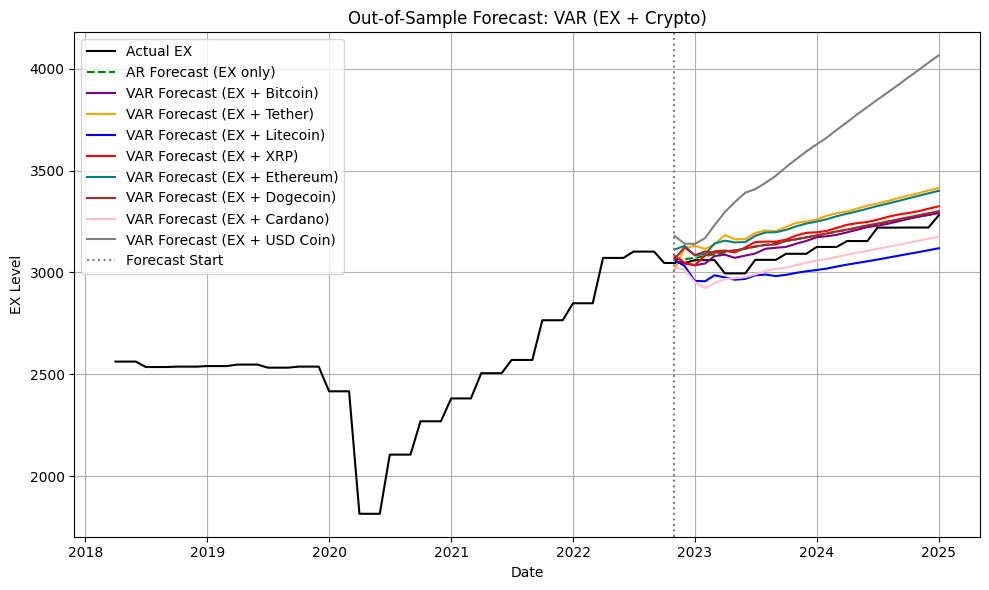

In [1119]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_gdp, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual gdp
plt.plot(df['EX'], label='Actual EX', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (gdp only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (EX only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label = 'VAR Forecast (EX + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (EX + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (EX + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (EX + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (EX + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (EX + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (EX + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (EX + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (EX + Crypto)')
plt.xlabel('Date')
plt.ylabel('EX Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1120]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (EX only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['EX'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (EX only) MAPE: 1.80%
VAR + BTC    MAPE: 1.42%
VAR + USDT   MAPE: 4.34%
VAR + LTC    MAPE: 2.95%
VAR + XRP    MAPE: 2.32%
VAR + ETH    MAPE: 3.96%
VAR + DOGE   MAPE: 1.99%
VAR + ADA    MAPE: 2.07%
VAR + USDC   MAPE: 15.01%


In [1121]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

cryptos = {
    'Bitcoin':  'Bitcoin',
    'Tether':   'usdt_diff',
    'Litecoin': 'Litecoin',
    'XRP':      'xrp_diff',
    'Ethereum': 'eth_diff',
    'Dogecoin': 'Dogecoin',
    'Cardano':  'ada_diff',
    'USD Coin': 'USD Coin',
}

p = 6
f_test_results = {}

for name, col in cryptos.items():
    # 1) Fit VAR
    df2   = train[['ex_diff', col]].dropna()
    res   = VAR(df2).fit(p)

    # 2) Extract r‐residuals
    resid_df = pd.DataFrame(
        res.resid, 
        index=df2.index[p:]
    )
    eps_ex    = resid_df.iloc[:, 0]

    # 3) Build lag matrix Z
    lags = {f"ex_lag{i}": df2['ex_diff'].shift(i) for i in range(1, p+1)}
    lags.update({f"{name}_lag{i}": df2[col].shift(i) for i in range(0, p+1)})
    Z = pd.DataFrame(lags).dropna().loc[eps_ex.index]
    eps_ex = eps_ex.loc[Z.index]

    # 4) Aux OLS
    aux = sm.OLS(eps_ex, sm.add_constant(Z)).fit()

    # 5) Wald χ² on the crypto lags
    crypto_terms = [f"{name}_lag{i}" for i in range(p+1)]
    R = np.zeros((p+1, aux.params.shape[0]))
    param_idx = {param: i for i, param in enumerate(aux.params.index)}
    for i, term in enumerate(crypto_terms):
        R[i, param_idx[term]] = 1.0

    wald = aux.wald_test(R)  # asymptotic χ²
    f_test_results[name] = {
        'χ² statistic': float(wald.statistic),
        'p-value':       float(wald.pvalue)
    }

# Summarize
f_test_df = pd.DataFrame(f_test_results).T
print(f_test_df)


          χ² statistic   p-value
Bitcoin       0.784626  0.604678
Tether        0.000244  1.000000
Litecoin      1.339783  0.261451
XRP           1.176798  0.340938
Ethereum      2.200298  0.058172
Dogecoin      0.014267  0.999997
Cardano       1.341424  0.260739
USD Coin      0.194251  0.984025


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/3991865896.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Des

## VAR Forecasting on CC with all crypto

ETH improves MAPE by 7.83%

In [1122]:
diff_orders = {
    "CC": 1,
    "Bitcoin": 0, 
    "Tether": 1,
    "Litecoin": 0,
    "XRP": 1,
    "Ethereum": 1,
    "Dogecoin": 0,
    "Cardano": 1,
    "USD Coin": 0,    
}
df_transformed = pd.DataFrame(index=df.index)
for col, d in diff_orders.items():
    if d > 0:
        df_transformed[col] = df[col].diff(d)
    else:
        df_transformed[col] = df[col]
# 3) Drop the NaNs introduced by differencing
df_transformed = df_transformed.dropna()
# 4) Fit the VAR and select the optimal lag
model = VAR(df_transformed)
lag_Res = model.select_order(maxlags=6)
print(lag_res.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -3.497     -3.201*     0.03029      -3.380
1      -4.775      -1.813    0.008614      -3.603
2      -4.476       1.151     0.01314      -2.249
3      -4.966       3.326     0.01138      -1.685
4      -4.799       6.159     0.02871     -0.4631
5      -6.081       7.542     0.03713     -0.6903
6     -13.32*       2.971  0.0007304*     -6.872*
-------------------------------------------------


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [1123]:
# Because lfpr is non-stationary with order 1, need to difference it
df['cc_diff'] = df['CC'].diff(1)
df['usdt_diff'] = df['Tether'].diff(1)
df['xrp_diff'] = df['XRP'].diff(1)
df['eth_diff'] = df['Ethereum'].diff(1)
df['ada_diff'] = df['Cardano'].diff(1)

df = df.dropna(subset=['usdt_diff'])

In [1124]:
from statsmodels.tsa.api import AutoReg

# Ensure 'cc_diff' exists in train
if 'cc_diff' not in train.columns:
    # Only assign values where the index exists in both
    common_idx = train.index.intersection(df['cc_diff'].dropna().index)
    train.loc[common_idx, 'cc_diff'] = df.loc[common_idx, 'cc_diff']

# Drop NaNs from the training data
cc_diff_train = train['cc_diff'].dropna()

model_ar = AutoReg(cc_diff_train, lags=2)
results_ar = model_ar.fit()

# Forecast the next len(test) steps
forecast2 = results_ar.forecast(steps=len(test))

/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [1125]:
cc_start = df['CC'].loc[train.index[-1]]
forecast_ar_level = forecast2.cumsum() + cc_start

In [1126]:
p = 6

# Ensure train has the latest differenced columns from df
train = df.loc['2017-09':'2022-10']

# Fit VAR model on cc_diff and Bitcoin
model_btc = VAR(train[['cc_diff', 'Bitcoin']].dropna())
results_btc = model_btc.fit(6)
forecast_btc = results_btc.forecast(train[['cc_diff', 'Bitcoin']].dropna().values[-p:], steps=len(test))
forecast_diff_btc = forecast_btc[:, 0]
forecast_var_btc = pd.Series(forecast_diff_btc.cumsum() + cc_start, index=test.index)

# Fit VAR model on cc_diff and usdt_diff
if 'usdt_diff' not in train.columns:
	train['usdt_diff'] = df['usdt_diff'].loc[train.index]
model_usdt = VAR(train[['cc_diff', 'usdt_diff']].dropna())
results_usdt = model_usdt.fit(6)
forecast_usdt = results_usdt.forecast(train[['cc_diff', 'usdt_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_usdt = forecast_usdt[:, 0]
forecast_var_usdt = pd.Series(forecast_diff_usdt.cumsum() + cc_start, index=test.index)

# Fit VAR model on cc_diff and Litecoin
model_ltc = VAR(train[['cc_diff', 'Litecoin']].dropna())
results_ltc = model_ltc.fit(6)
forecast_ltc = results_ltc.forecast(train[['cc_diff', 'Litecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_ltc = forecast_ltc[:, 0]
forecast_var_ltc = pd.Series(forecast_diff_ltc.cumsum() + cc_start, index=test.index)

# Fit VAR model on cc_diff and xrp_diff
model_xrp = VAR(train[['cc_diff', 'xrp_diff']].dropna())
results_xrp = model_xrp.fit(6)
forecast_xrp = results_xrp.forecast(train[['cc_diff', 'xrp_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_xrp = forecast_xrp[:, 0]
forecast_var_xrp = pd.Series(forecast_diff_xrp.cumsum() + cc_start, index=test.index)

# Fit VAR model on cc_diff and eth_diff
model_eth = VAR(train[['cc_diff', 'eth_diff']].dropna())
results_eth = model_eth.fit(6)
forecast_eth = results_eth.forecast(train[['cc_diff', 'eth_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_eth = forecast_eth[:, 0]
forecast_var_eth = pd.Series(forecast_diff_eth.cumsum() + cc_start, index=test.index)

# Fit VAR model on cc_diff and Dogecoin
model_doge = VAR(train[['cc_diff', 'Dogecoin']].dropna())
results_doge = model_doge.fit(6)
forecast_doge = results_doge.forecast(train[['cc_diff', 'Dogecoin']].dropna().values[-p:], steps=len(test))
forecast_diff_doge = forecast_doge[:, 0]
forecast_var_doge = pd.Series(forecast_diff_doge.cumsum() + cc_start, index=test.index)

# Fit VAR model on cc_diff and ada_diff
model_ada = VAR(train[['cc_diff', 'ada_diff']].dropna())
results_ada = model_ada.fit(6)
forecast_ada = results_ada.forecast(train[['cc_diff', 'ada_diff']].dropna().values[-p:], steps=len(test))
forecast_diff_ada = forecast_ada[:, 0]
forecast_var_ada = pd.Series(forecast_diff_ada.cumsum() + cc_start, index=test.index)

# Fit VAR model on cc_diff and USD Coin
model_usdc = VAR(train[['cc_diff', 'USD Coin']].dropna())
results_usdc = model_usdc.fit(6)
forecast_usdc = results_usdc.forecast(train[['cc_diff', 'USD Coin']].dropna().values[-p:], steps=len(test))
forecast_diff_usdc = forecast_usdc[:, 0]
forecast_var_usdc = pd.Series(forecast_diff_usdc.cumsum() + cc_start, index=test.index)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

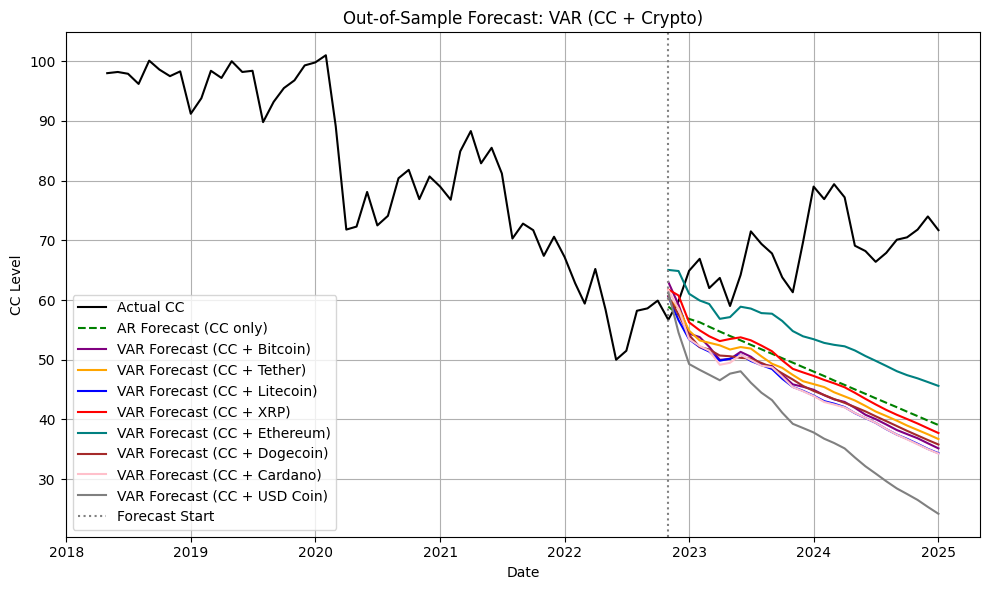

In [1127]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume these are your series (replace with your actual forecast Series)
# actual_gdp, forecast_ar_level, forecast_var_btc, ..., forecast_var_usdc should all be pandas Series
# test is your test set with a DateTime index

plt.figure(figsize=(10, 6))

# Plot actual gdp
plt.plot(df['CC'], label='Actual CC', color='black')

# Plot AR forecast
# plt.plot(forecast_ar_level, label='AR Forecast (gdp only)', linestyle='--', color='green')
plt.plot(forecast_ar_level, label='AR Forecast (CC only)', linestyle='--', color='green')
# Plot VAR forecasts for each crypto
plt.plot(forecast_var_btc, label = 'VAR Forecast (CC + Bitcoin)', color='purple')
plt.plot(forecast_var_usdt, label='VAR Forecast (CC + Tether)', color='orange')
plt.plot(forecast_var_ltc, label='VAR Forecast (CC + Litecoin)', color='blue')
plt.plot(forecast_var_xrp, label='VAR Forecast (CC + XRP)', color='red')
plt.plot(forecast_var_eth, label='VAR Forecast (CC + Ethereum)', color='teal')
plt.plot(forecast_var_doge, label='VAR Forecast (CC + Dogecoin)', color='brown')
plt.plot(forecast_var_ada, label='VAR Forecast (CC + Cardano)', color='pink')
plt.plot(forecast_var_usdc, label='VAR Forecast (CC + USD Coin)', color='gray')

# Forecast start line
plt.axvline(pd.to_datetime(test.index[0]), linestyle=':', color='gray', label='Forecast Start')

# Labels and legend
plt.title('Out-of-Sample Forecast: VAR (CC + Crypto)')
plt.xlabel('Date')
plt.ylabel('CC Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1128]:
from sklearn.metrics import mean_absolute_percentage_error

# 1) Collect your forecasts in a dict
forecasts = {
    'AR (CC only)'  : forecast_ar_level,
    'VAR + BTC'    : forecast_var_btc,
    'VAR + USDT'   : forecast_var_usdt,
    'VAR + LTC'    : forecast_var_ltc,
    'VAR + XRP'    : forecast_var_xrp,
    'VAR + ETH'    : forecast_var_eth,
    'VAR + DOGE'   : forecast_var_doge,
    'VAR + ADA'    : forecast_var_ada,
    'VAR + USDC'   : forecast_var_usdc,
}

# 2) Actuals over the test period
actual = df['CC'].loc[test.index]

# 3) Loop and compute MAPE
for name, fc in forecasts.items():
    mape = mean_absolute_percentage_error(actual, fc) * 100
    print(f"{name:12s} MAPE: {mape:.2f}%")


AR (CC only) MAPE: 27.83%
VAR + BTC    MAPE: 32.32%
VAR + USDT   MAPE: 30.58%
VAR + LTC    MAPE: 33.26%
VAR + XRP    MAPE: 28.90%
VAR + ETH    MAPE: 21.00%
VAR + DOGE   MAPE: 32.10%
VAR + ADA    MAPE: 33.28%
VAR + USDC   MAPE: 41.86%


In [1129]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

cryptos = {
    'Bitcoin':  'Bitcoin',
    'Tether':   'usdt_diff',
    'Litecoin': 'Litecoin',
    'XRP':      'xrp_diff',
    'Ethereum': 'eth_diff',
    'Dogecoin': 'Dogecoin',
    'Cardano':  'ada_diff',
    'USD Coin': 'USD Coin',
}

p = 6
f_test_results = {}

for name, col in cryptos.items():
    # 1) Fit VAR
    df2   = train[['cc_diff', col]].dropna()
    res   = VAR(df2).fit(p)

    # 2) Extract r‐residuals
    resid_df = pd.DataFrame(
        res.resid, 
        index=df2.index[p:]
    )
    eps_cc    = resid_df.iloc[:, 0]

    # 3) Build lag matrix Z
    lags = {f"cc_lag{i}": df2['cc_diff'].shift(i) for i in range(1, p+1)}
    lags.update({f"{name}_lag{i}": df2[col].shift(i) for i in range(0, p+1)})
    Z = pd.DataFrame(lags).dropna().loc[eps_cc.index]
    eps_cc = eps_cc.loc[Z.index]

    # 4) Aux OLS
    aux = sm.OLS(eps_cc, sm.add_constant(Z)).fit()

    # 5) Wald χ² on the crypto lags
    crypto_terms = [f"{name}_lag{i}" for i in range(p+1)]
    R = np.zeros((p+1, aux.params.shape[0]))
    param_idx = {param: i for i, param in enumerate(aux.params.index)}
    for i, term in enumerate(crypto_terms):
        R[i, param_idx[term]] = 1.0

    wald = aux.wald_test(R)  # asymptotic χ²
    f_test_results[name] = {
        'χ² statistic': float(wald.statistic),
        'p-value':       float(wald.pvalue)
    }

# Summarize
f_test_df = pd.DataFrame(f_test_results).T
print(f_test_df)


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/1897908430.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Des

          χ² statistic   p-value
Bitcoin       0.044080  0.999863
Tether        0.005035  1.000000
Litecoin      0.082790  0.998901
XRP           0.195602  0.984356
Ethereum      0.731395  0.646731
Dogecoin      0.010822  0.999999
Cardano       0.268085  0.962151
USD Coin      0.526306  0.806487


/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/var/folders/4f/hw3jnnqj605gnnq33z6q3ny00000gn/T/ipykernel_88561/1897908430.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'χ² statistic': float(wald.statistic),
/Users/aliceye/Desktop/CryptoMacroecon-Prediction-CSUREMM/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/aliceye/Des